In [360]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [361]:
movies_dataframe = pd.read_csv('movie_metadata.csv')
movies_dataframe.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [362]:
movies_dataframe.shape

(5043, 28)

In [363]:
# PRE-PROCESSING

# Remove all movies made outside the USA
movies_dataframe = movies_dataframe.drop(movies_dataframe[movies_dataframe.country != 'USA'].index)
# Any block with missing information is dropped
movies_dataframe.dropna()


# Calculate profit to adjust for inflation
# Subtract budget from gross to calculate profits and add it as a new feature
movies_dataframe['profit'] = np.subtract(movies_dataframe['gross'].values, movies_dataframe['budget'].values)

movies_dataframe['profitpercent'] = np.subtract(movies_dataframe['gross'].values, movies_dataframe['budget'].values)
movies_dataframe['profitpercent'] = np.divide(movies_dataframe['profitpercent'].values, movies_dataframe['gross'].values)
movies_dataframe['profitpercent'] = np.multiply(movies_dataframe['profitpercent'].values, 100)

movies_dataframe = movies_dataframe.fillna(0)


movies_dataframe.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,profit,profitpercent
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,523505847.0,68.836532
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,9404152.0,3.039439
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,198130642.0,44.212697
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000,-190641321.0,-260.942743
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0,78530303.0,23.335284


In [364]:
movies_dataframe.shape

(3807, 30)

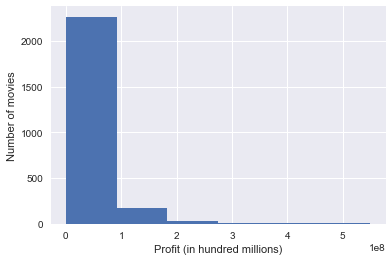

profit    523505847.0
dtype: float64


In [366]:
# Graph for Profits vs Number of Movies
%matplotlib inline
plt.hist(movies_dataframe['profit'], bins=6, normed=False, range=(0, 550000000))

plt.xlabel('Profit (in hundred millions)')
plt.ylabel('Number of movies')
plt.show()

# We also want to see what the most profitable movie in our dataset made
max_profit = movies_dataframe[['profit']].max()
print(max_profit)

<dl>
    <dt><h3>Movie Info</h3></dt>
    <dd><em>IMDB Score, Budget, Duration, Title Year</em></dd>
</dl>

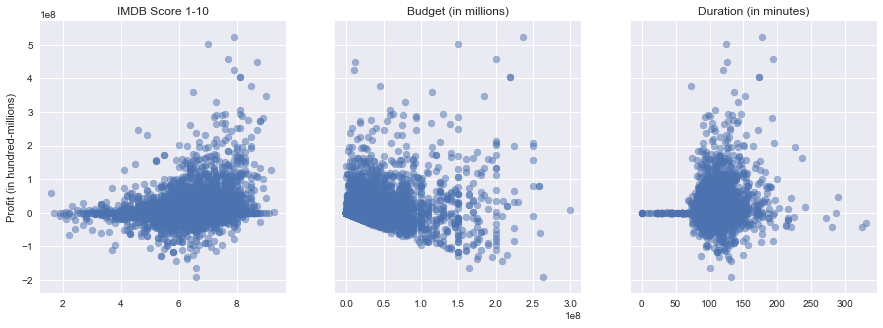

In [367]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (15, 5))
ax1.scatter(movies_dataframe['imdb_score'], movies_dataframe['profit'], alpha = 0.5)
ax2.scatter(movies_dataframe['budget'], movies_dataframe['profit'], alpha = 0.5)
ax3.scatter(movies_dataframe['duration'], movies_dataframe['profit'], alpha = 0.5)

ax1.set_ylabel('Profit (in hundred-millions)')
ax1.set_title('IMDB Score 1-10')
ax2.set_title('Budget (in millions)')
ax3.set_title('Duration (in minutes)')

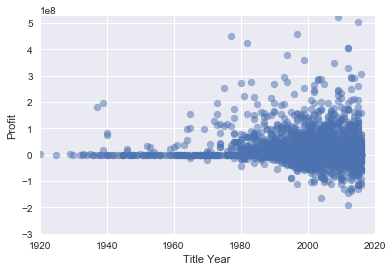

In [368]:
# Profit vs. Title Year

x_axis = movies_dataframe[['title_year']]
y = movies_dataframe[['profit']]

plt.ylabel('Profit')
plt.xlabel('Title Year')

plt.ylim([-300000000, 525000000])   #Profit range of -$300M - $525M
plt.xlim([1920, 2020])              #Title Year range of 1920 - 2020
plt.scatter(x_axis, y, alpha=0.5)
plt.show()

<dl>
    <dt></dt>
    <dd>Patterns that correlate with a movie's profit can clearly be seen with IMDB score, budget, and duration.  IMDB Score shows a relative rise in profit as a movie's rating increases to a point.  Budget and duration show that most movies follow a standard format.
    <br /><br />
    Title Year should be evaluated with a bit of scrutiny.  The vast majority of samples occur after the year 1980.  Profit values have also not been adjusted for inflation which would also explain for such a rise in earnings for movies.  To adjust for this we will consider movies before 1980 to be outliers and drop them from the dataset.  This fits within the scope of this project as recent movies will have the largest impact.  This will be our new dataset.</dd>
</dl>

In [369]:
# Drop samples with Title Year before 1980
movies_dataframe = movies_dataframe.drop(movies_dataframe[movies_dataframe.title_year < 1980].index)

# Checking new dataframe size for change.  OLD: (3793, 29)
movies_dataframe.shape

(3529, 30)

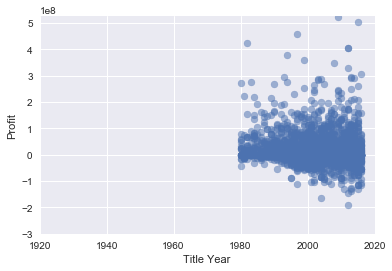

In [370]:
# Profit vs. Title Year (Revised)

x_axis = movies_dataframe[['title_year']]
y = movies_dataframe[['profit']]
%matplotlib inline

plt.ylabel('Profit')
plt.xlabel('Title Year')

plt.ylim([-300000000, 525000000])   #Profit range of -$300M - $525M
plt.xlim([1920, 2020])              #Title Year range of 1920 - 2020 to show change
plt.scatter(x_axis, y, alpha=0.5)
plt.show()

<dl>
    <dt><h3>Ratings Info</h3></dt>
    <dd><em>Number of Critic Reviews, User Reviews, Voted Users</em></dd>
</dl>

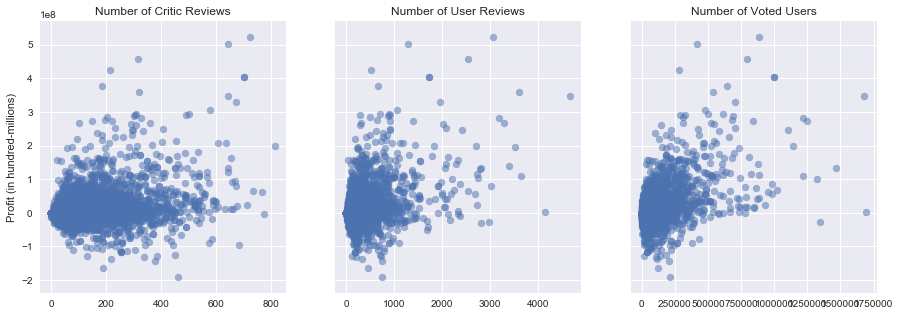

In [371]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (15, 5))
ax1.scatter(movies_dataframe['num_critic_for_reviews'], movies_dataframe['profit'], alpha = 0.5)
ax2.scatter(movies_dataframe['num_user_for_reviews'], movies_dataframe['profit'], alpha = 0.5)
ax3.scatter(movies_dataframe['num_voted_users'], movies_dataframe['profit'], alpha = 0.5)

ax1.set_ylabel('Profit (in hundred-millions)')
ax1.set_title('Number of Critic Reviews')
ax2.set_title('Number of User Reviews')
ax3.set_title('Number of Voted Users')

<dl>
    <dt></dt>
    <dd>All three ratings features present valuable information.
    </dd>
</dl>

<dl>
    <dt><h3>Miscellaneous</h3></dt>
    <dd><em>Face Number in Poster, Color</em></dd>
</dl>

In [372]:
# Function to convert color values to binary values
def color_to_numeric(x):
    if x == 'Color':
        return 1;
    else:
        return 0;
    
# Creates a new feature named colorlabel using converted values
movies_dataframe['colorlabel'] = movies_dataframe['color'].apply(color_to_numeric)
movies_dataframe.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,profit,profitpercent,colorlabel
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,523505847.0,68.836532,1
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,9404152.0,3.039439,1
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,198130642.0,44.212697,1
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000,-190641321.0,-260.942743,1
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0,78530303.0,23.335284,1


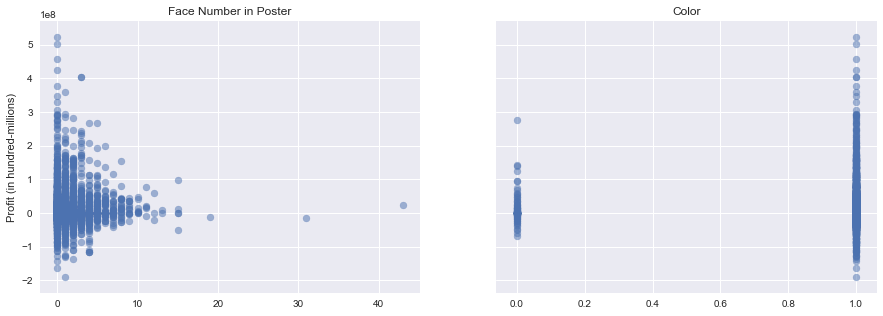

In [373]:
figure, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (15, 5))
ax1.scatter(movies_dataframe['facenumber_in_poster'], movies_dataframe['profit'], alpha = 0.5)
ax2.scatter(movies_dataframe['colorlabel'], movies_dataframe['profit'], alpha = 0.5)

ax1.set_ylabel('Profit (in hundred-millions)')
ax1.set_title('Face Number in Poster')
ax2.set_title('Color')

<dl>
    <dt></dt>
    <dd>Facenumber in Poster is surprisingly informative.  It shows that the number of faces in a movie poster correlates negatively with a movie's profits.  Movies with 0 faces tend to do much better than movies with even just 1 face and linearly decreases as more faces are added.
    <br /><br />
    Color's results are expected.  Almost all recent movies are color, but there are a fair amount of samples for black and white movies and many that did well.
    </dd>
</dl>

<dl>
    <dt><h3>Facebook Info</h3></dt>
    <dd><em>Movie Facebook Likes, Cast Total Facebook Likes, Director Facebook Likes</em></dd>
</dl>

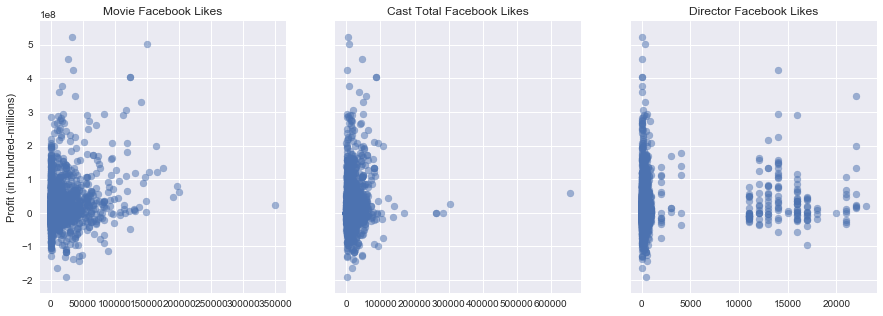

In [374]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (15, 5))
ax1.scatter(movies_dataframe['movie_facebook_likes'], movies_dataframe['profit'], alpha = 0.5)
ax2.scatter(movies_dataframe['cast_total_facebook_likes'], movies_dataframe['profit'], alpha = 0.5)
ax3.scatter(movies_dataframe['director_facebook_likes'], movies_dataframe['profit'], alpha = 0.5)

ax1.set_ylabel('Profit (in hundred-millions)')
ax1.set_title('Movie Facebook Likes')
ax2.set_title('Cast Total Facebook Likes')
ax3.set_title('Director Facebook Likes')

<dl>
    <dt></dt>
    <dd>Facebook's influence on a movie's profits can only be calculated on movies made after facebook's creation and rise in popularity.  To include facebook's data in our dataset we would need to eliminate many movies from the dataset.  It is for this reason any of the facebook features will not be included.  Nevertheless, it is still interesting to see what the pyplots show for the data. <br  />
    </dd>
</dl>

### Determining most influential features

In [375]:
movies_dataframe.corr()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,profit,profitpercent,colorlabel
num_critic_for_reviews,1.000000,0.339069,0.201205,0.292630,0.175311,0.531061,0.628900,0.256454,-0.031862,0.608504,0.534529,0.339507,0.293529,0.367705,0.176057,0.693613,0.272649,0.051040,0.022071
duration,0.339069,1.000000,0.226411,0.163483,0.101585,0.323073,0.396707,0.149146,-0.003864,0.402561,0.365441,-0.092281,0.168870,0.349002,0.136566,0.274345,0.134567,0.020569,-0.028400
director_facebook_likes,0.201205,0.226411,1.000000,0.130256,0.085051,0.155498,0.330539,0.118041,-0.046420,0.253392,0.118398,-0.073613,0.129350,0.205339,0.040604,0.180206,0.114599,0.011758,-0.067127
actor_3_facebook_likes,0.292630,0.163483,0.130256,1.000000,0.236879,0.315519,0.293939,0.460005,0.105495,0.235080,0.286322,0.105415,0.553576,0.090680,0.045533,0.307182,0.192799,0.013228,0.028898
actor_1_facebook_likes,0.175311,0.101585,0.085051,0.236879,1.000000,0.139836,0.175130,0.952278,0.071485,0.130799,0.158804,0.059463,0.372801,0.122642,0.031149,0.119856,0.060780,0.010886,-0.004274
gross,0.531061,0.323073,0.155498,0.315519,0.139836,1.000000,0.659994,0.232153,-0.028152,0.577870,0.682572,0.021446,0.268513,0.265604,0.103065,0.398655,0.790510,0.058553,0.037292
num_voted_users,0.628900,0.396707,0.330539,0.293939,0.175130,0.659994,1.000000,0.251000,-0.037500,0.796017,0.459680,-0.004610,0.265491,0.473722,0.103093,0.537775,0.518775,0.036536,-0.019773
cast_total_facebook_likes,0.256454,0.149146,0.118041,0.460005,0.952278,0.232153,0.251000,1.000000,0.091175,0.195517,0.240527,0.086278,0.612788,0.142598,0.046387,0.201489,0.118214,0.015267,0.005689
facenumber_in_poster,-0.031862,-0.003864,-0.046420,0.105495,0.071485,-0.028152,-0.037500,0.091175,1.000000,-0.082001,-0.022411,0.115082,0.069607,-0.072491,-0.011633,0.007283,-0.019027,-0.011751,0.029038
num_user_for_reviews,0.608504,0.402561,0.253392,0.235080,0.130799,0.577870,0.796017,0.195517,-0.082001,1.000000,0.459116,-0.026175,0.220929,0.339101,0.111627,0.412292,0.405994,0.039495,-0.042685


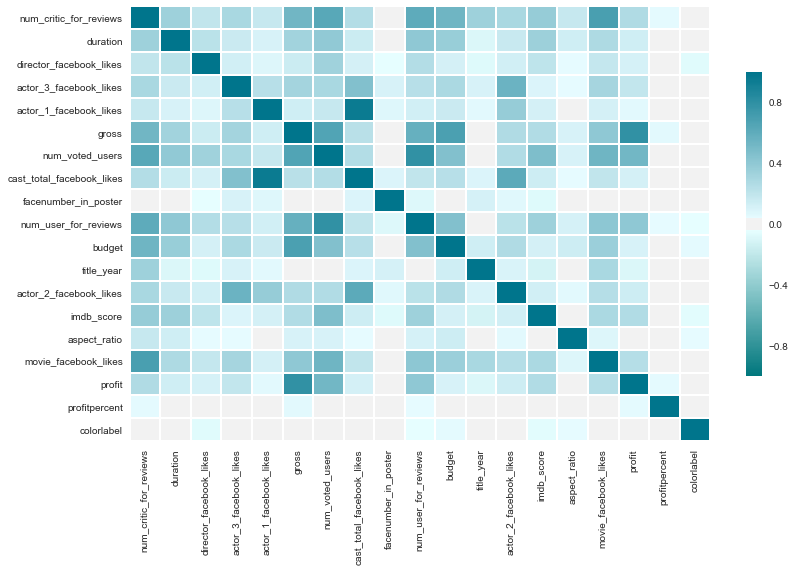

In [376]:
fig, axn = plt.subplots(figsize = (13, 8))
sns.heatmap(movies_dataframe.corr(),
            cmap = sns.diverging_palette(200, 220, 100, l = 45, n = 7, 
                                         as_cmap = True), 
            cbar_kws = {'shrink': 0.7},
            linewidths = 1,
            ax = axn)

It doesn't look like any features have a large enough impact on profitpercent to be considered influential.

<dl>
    <dt><h3>K-Nearest Neighbors</h3></dt>
    <dd><em>Using KNN to determine whether profit is really independent of other features.</em></dd>
</dl>

In [377]:
# Function casts input into an integer and measures whether or not a movie made ANY profit
# New feature named 'profitlabel' is added to our dataset

def profit_to_numeric(x):
    int(x)
    if x == 0:      # If profit = 0
        return 0
    elif x < 0:     # If profit < 0
        return 1
    elif x > 0:     # If profit > 0
        return 2
    
movies_dataframe['profitlabel'] = movies_dataframe['profit'].apply(profit_to_numeric)
movies_dataframe.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,profit,profitpercent,colorlabel,profitlabel
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,237000000.0,2009.0,936.0,7.9,1.78,33000,523505847.0,68.836532,1,2
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,300000000.0,2007.0,5000.0,7.1,2.35,0,9404152.0,3.039439,1,2
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,250000000.0,2012.0,23000.0,8.5,2.35,164000,198130642.0,44.212697,1,2
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,263700000.0,2012.0,632.0,6.6,2.35,24000,-190641321.0,-260.942743,1,1
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,258000000.0,2007.0,11000.0,6.2,2.35,0,78530303.0,23.335284,1,2


In [378]:
print('Feature                        KNN Score')
print('---------------------------------------------')

y = movies_dataframe['profitlabel']
knn = KNeighborsClassifier(n_neighbors = 16)

X = movies_dataframe[['imdb_score']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print('IMDB Score:                   ', score)



X = movies_dataframe[['colorlabel']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print('ColorLabel:                   ', score)



X = movies_dataframe[['num_user_for_reviews']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print('Number of User Reviews:       ', score)



X = movies_dataframe[['budget']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print('Budget:                       ', score)



X = movies_dataframe[['facenumber_in_poster']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print('Face Number in Poster:        ', score)



X = movies_dataframe[['title_year']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print('Title Year:                   ', score)



X = movies_dataframe[['num_critic_for_reviews']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print('Number of Critic Reviews:     ', score)



X = movies_dataframe[['num_voted_users']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print('Number of Voted Users:        ', score)



X = movies_dataframe[['duration']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print('Duration:                     ', score)


X = movies_dataframe[['imdb_score', 'budget', 'duration', 'title_year', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'facenumber_in_poster']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print('')
print('KNN TOTAL:                    ', score)

Feature                        KNN Score
---------------------------------------------
IMDB Score:                    0.495750708215
ColorLabel:                    0.466477809254
Number of User Reviews:        0.540132200189
Budget:                        0.508970727101
Face Number in Poster:         0.327667610954
Title Year:                    0.42492917847
Number of Critic Reviews:      0.508026440038
Number of Voted Users:         0.559962228517
Duration:                      0.481586402266

KNN TOTAL:                     0.61284230406


### KNN Conlusion:

Almost all features project a 50% prediction rate, give or take 5%; not much better than randomly guessing.  While the two features with the highest KNN scores, number of voted users and number of user reviews with 55.9% and 54% respectively, transpire post-production there is still not enough of a correlation to make a veritable claim.

### Testing other methods of predicting profitability of movies

In [379]:
X = movies_dataframe[['imdb_score', 'budget', 'duration', 'title_year', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'facenumber_in_poster']]
y = movies_dataframe['profitlabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=16)
logreg = LogisticRegression()
decisiontree = DecisionTreeClassifier(random_state = 2)
adaboost = AdaBoostClassifier(n_estimators=19)
randomforest = RandomForestClassifier(n_estimators=19, bootstrap=True, random_state=2)

knn.fit(X_train, y_train)
logreg.fit(X_train, y_train)
decisiontree.fit(X_train, y_train)
adaboost.fit(X_train, y_train)
randomforest.fit(X_train, y_train)

knnPredict = knn.predict(X_test)
logregPredict = logreg.predict(X_test)
dectreePredict = decisiontree.predict(X_test)
adaPredict = adaboost.predict(X_test)
forestPredict = randomforest.predict(X_test)

knnScore = accuracy_score(y_test, knnPredict)
logregScore = accuracy_score(y_test, logregPredict)
dectreeScore = accuracy_score(y_test, dectreePredict)
adaScore = accuracy_score(y_test, adaPredict)
forestScore = accuracy_score(y_test, forestPredict)

print("KNN Score:            ", end="")
print(knnScore)
print("LogReg Score:         ", end="")
print(logregScore)
print("DecTree Score:        ", end="")
print(dectreeScore)
print("AdaBoost Score:       ", end="")
print(adaScore)
print("RandomForest Score:   ", end="")
print(forestScore)

KNN Score:            0.61284230406
LogReg Score:         0.649669499528
DecTree Score:        0.650613786591
AdaBoost Score:       0.66761095373
RandomForest Score:   0.706326723324
